In [1]:
import sionna as sn
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

2023-06-29 13:12:26.824581: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-29 13:12:26.827003: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-29 13:12:26.871098: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-29 13:12:26.871821: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-29 13:12:27.964213: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
BATCH_SIZE = 300
NUM_BS_ANT = 8
NUM_UT = 8
NUM_STREAMS_PER_TX = 2

NUM_BITS_PER_SYMBOL = 4
CODERATE = 0.5

BS_HEIGHT = 15.0
MAX_UT_HEIGHT = 2.0
MIN_UT_HEIGHT = 1.0

CARRIER_FREQUENCY = 1.9e9

In [3]:
rx_tx_association = np.ones([1, NUM_UT])

stream_management = sn.mimo.StreamManagement(
    rx_tx_association=rx_tx_association,
    num_streams_per_tx=NUM_STREAMS_PER_TX 
)

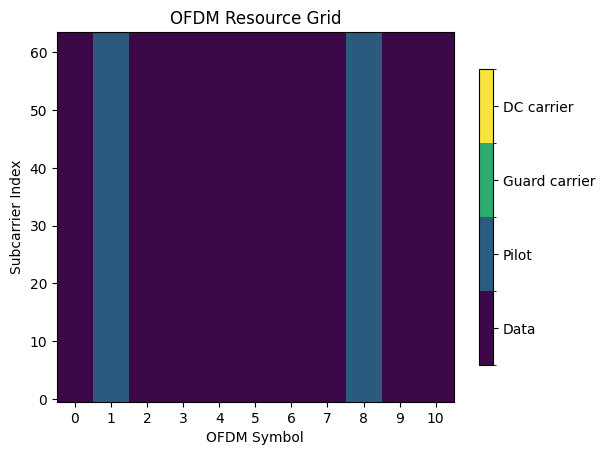

In [4]:
resource_grid = sn.ofdm.ResourceGrid(
    num_ofdm_symbols=11,
    fft_size=32,
    subcarrier_spacing=30e3,
    num_tx=NUM_UT,
    num_streams_per_tx=NUM_STREAMS_PER_TX,
    cyclic_prefix_length=6,
    pilot_pattern="kronecker",
    pilot_ofdm_symbol_indices=[1,9]
)

resource_grid_mapper = sn.ofdm.ResourceGridMapper(resource_grid=resource_grid)
frequencies = sn.channel.subcarrier_frequencies(
    num_subcarriers=resource_grid.fft_size,
    subcarrier_spacing=resource_grid.subcarrier_spacing
)

resource_grid.show();

In [5]:
NUM_CODED_BITS = int(resource_grid.num_data_symbols * NUM_BITS_PER_SYMBOL)
NUM_INFO_BITS = int(NUM_CODED_BITS * CODERATE)


class CellModel(tf.keras.Model):
    
    def __init__(self, scenario='umi'):

        super().__init__()

        self.binary_source = sn.utils.BinarySource()

        constellation = sn.mapping.Constellation('qam', NUM_BITS_PER_SYMBOL)
        self.mapper = sn.mapping.Mapper(constellation=constellation)
        self.demapper = sn.mapping.Demapper('app', constellation=constellation)

        self.encoder = sn.fec.ldpc.LDPC5GEncoder(NUM_INFO_BITS, NUM_CODED_BITS)
        self.decoder = sn.fec.ldpc.LDPC5GDecoder(encoder=self.encoder, hard_out=True)

        self.ls_est = sn.ofdm.LSChannelEstimator(resource_grid=resource_grid, interpolation_type='nn')

        self.lmmse_equ = sn.ofdm.LMMSEEqualizer(resource_grid=resource_grid, stream_management=stream_management)

        self.channel_freq = sn.channel.ApplyOFDMChannel(add_awgn=True)

        self.ut_array = sn.channel.tr38901.Antenna(
            polarization='dual',
            polarization_type='cross',
            antenna_pattern='omni',
            carrier_frequency=CARRIER_FREQUENCY
        )

        self.bs_array = sn.channel.tr38901.AntennaArray(
            num_rows=1,
            num_cols=NUM_BS_ANT,
            polarization='dual',
            polarization_type='cross',
            antenna_pattern='38.901',
            # antenna_pattern='omni',
            carrier_frequency=CARRIER_FREQUENCY
        )

        topology = sn.channel.gen_single_sector_topology(
            batch_size=BATCH_SIZE,
            indoor_probability=0,
            num_ut=NUM_UT,
            scenario=scenario,
            bs_height=BS_HEIGHT,
            max_ut_height=MAX_UT_HEIGHT,
            min_ut_height=MIN_UT_HEIGHT
        )

        if scenario == 'umi':
            self.channel_model=sn.channel.tr38901.UMi(
                carrier_frequency=CARRIER_FREQUENCY,
                o2i_model='low',
                ut_array=self.ut_array,
                bs_array=self.bs_array,
                direction='uplink',
                enable_pathloss=False,
                enable_shadow_fading=False
            )
        elif scenario == 'uma':
            self.channel_model = sn.channel.tr38901.UMa(
                carrier_frequency=CARRIER_FREQUENCY,
                o2i_model="low",
                ut_array=self.ut_array,
                bs_array=self.bs_array,
                direction='uplink',
                enable_pathloss=False,
                enable_shadow_fading=False
            )
    
        self.channel_model.set_topology(*topology)

    @tf.function
    def __call__(self, batch_size, ebno_db):

        no = sn.utils.ebnodb2no(
            coderate=CODERATE,
            num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
            resource_grid=resource_grid,
            ebno_db=ebno_db
        ) 

        bits = self.binary_source([
            batch_size,
            NUM_UT,
            resource_grid.num_streams_per_tx,
            NUM_INFO_BITS
        ])
        coded_bits = self.encoder(bits)
        qam_symbols = self.mapper(coded_bits)
        ofdm_symbols = resource_grid_mapper(qam_symbols)

        a, tau = self.channel_model(
            num_time_samples=resource_grid.num_ofdm_symbols,
            sampling_frequency=1/resource_grid.ofdm_symbol_duration
        )
        h_freq = sn.channel.cir_to_ofdm_channel(
            frequencies=frequencies,
            a=a,
            tau=tau,
            normalize=True
        )
        received_symbols = self.channel_freq([ofdm_symbols, h_freq, no])
        estimation, err_var = self.ls_est([received_symbols, no])
        equalized_symbols, no_eff = self.lmmse_equ([ received_symbols, estimation, err_var, no])
        llr = self.demapper([equalized_symbols, no_eff])
        bits_hat = self.decoder(llr)

        return bits, bits_hat
                

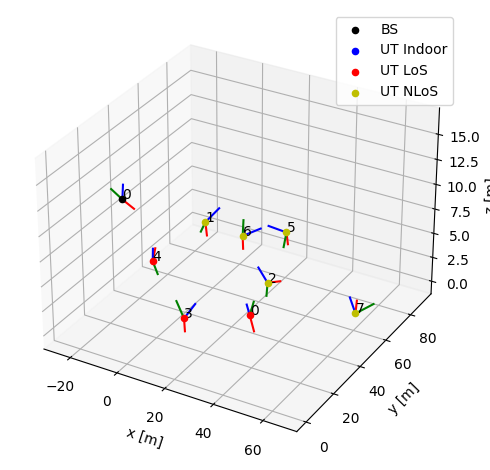

In [6]:
ber_plots = sn.utils.PlotBER('UAV Simulation')
umi_model = CellModel('umi')
uma_model = CellModel('uma')

umi_model.channel_model.show_topology();

In [7]:
ber_plots.simulate(
    umi_model,
    batch_size=BATCH_SIZE,
    ebno_dbs=np.linspace(-5,10,16),
    num_target_bit_errors=1000,
    legend='UMi',
    soft_estimates=False,
    max_mc_iter=1000,
    show_fig=False
);

2023-06-29 13:12:32.156096: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'batch_size' with dtype int32
	 [[{{node batch_size}}]]


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


2023-06-29 13:12:59.112816: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (mklcpu) ran out of memory trying to allocate 9.26GiB (rounded to 9948364800)requested by op mul_350
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-06-29 13:12:59.112896: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for mklcpu
2023-06-29 13:12:59.112912: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2023-06-29 13:12:59.112921: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2023-06-29 13:12:59.112929: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (1024): 	To

ResourceExhaustedError: Graph execution error:

Detected at node 'mul_350' defined at (most recent call last):
    File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/home/gabs/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/gabs/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/home/gabs/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/home/gabs/.local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 600, in run_forever
      self._run_once()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 1896, in _run_once
      handle._run()
    File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/gabs/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/home/gabs/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/home/gabs/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/home/gabs/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/home/gabs/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/home/gabs/.local/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/gabs/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "/home/gabs/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "/home/gabs/.local/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/gabs/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/gabs/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/gabs/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_78405/537292155.py", line 1, in <module>
      ber_plots.simulate(
    File "/home/gabs/.local/lib/python3.10/site-packages/sionna/utils/plotting.py", line 411, in simulate
      ber, bler = sim_ber(mc_fun,
    File "/home/gabs/.local/lib/python3.10/site-packages/sionna/utils/misc.py", line 633, in sim_ber
      outputs = mc_fun(batch_size=batch_size, ebno_db=ebno_dbs[i])
    File "/tmp/ipykernel_78405/1202049394.py", line 100, in __call__
      h_freq = sn.channel.cir_to_ofdm_channel(
    File "/home/gabs/.local/lib/python3.10/site-packages/sionna/channel/utils.py", line 230, in cir_to_ofdm_channel
      h_f = h*e
Node: 'mul_350'
OOM when allocating tensor with shape[300,1,16,8,2,23,11,64] and type complex64 on /job:localhost/replica:0/task:0/device:CPU:0 by allocator mklcpu
	 [[{{node mul_350}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference___call___15385]

In [ ]:
ber_plots.simulate(
    uma_model,
    batch_size=BATCH_SIZE,
    ebno_dbs=np.linspace(-5,10,16),
    num_target_bit_errors=1000,
    legend='UMa',
    soft_estimates=False,
    max_mc_iter=1000,
    show_fig=False
);

In [ ]:
ber_plots();